In [ ]:
import pandas as pd

# Step 1: Load the full dataset
df = pd.read_csv('/content/train.csv')

# Step 2: Subsample to 50,000 entries randomly (ensuring reproducibility)
df_50k = df.sample(n=50000, random_state=42).reset_index(drop=True)

# Step 3: Create the two data regimes
high_data_df = df_50k.sample(frac=0.01, random_state=1).reset_index(drop=True)   # 1% → 500 samples
scarce_data_df = df_50k.sample(frac=0.001, random_state=2).reset_index(drop=True)  # 0.1% → 50 samples

# Optional: Inspect the first few entries"
print("First 5 SMILES in 1% (High Data Regime):")
print(high_data_df['SMILES'].head())

print("\nFirst 5 SMILES in 0.1% (Scarce Data Regime):")
print(scarce_data_df['SMILES'].head())

# Summary
print(f"\nOriginal dataset size: {len(df)}")
print(f"Subset used for project: {len(df_50k)}")
print(f"High-data regime (1%): {len(high_data_df)} samples")
print(f"Scarce-data regime (0.1%): {len(scarce_data_df)} samples")

First 5 SMILES in 1% (High Data Regime):
0    Cc1c(C(=O)Nc2cc(F)cc(F)c2)cnn1-c1ccccc1
1       CCC(=O)C=c1[nH]c2nnc(N)n2c1=CC(=O)CC
2        CCC(CC)NC(=O)Cn1cc(Br)c(=O)[nH]c1=O
3            CC(Oc1ccc(C#N)cc1)C(=O)c1ccccc1
4           CCCCCC(C)NC(=O)c1cccc(NC(C)=O)c1
Name: SMILES, dtype: object

First 5 SMILES in 0.1% (Scarce Data Regime):
0           Cc1cc(C)n(C(=O)c2c(Cl)c(C)nn2C)n1
1        COc1ccc(C)cc1NC(=O)CSc1nccc(=O)[nH]1
2       CC(NC(=O)CNC(=O)c1cccc(Cl)c1)c1ccccc1
3        Cn1c2ccccc2c2nnc(SCC(=O)N3CCCC3)nc21
4    N#CCCN(C(=O)COC(=O)c1ccccc1O)c1ccc(F)cc1
Name: SMILES, dtype: object

Original dataset size: 199451
Subset used for project: 50000
High-data regime (1%): 500 samples
Scarce-data regime (0.1%): 50 samples


In [ ]:
pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 8.7 MB/s eta 0:00:00


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

def smiles_to_fp(smiles, radius=2, n_bits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits)
    return np.array(fp, dtype=int)

def dataframe_to_fps(df, col='SMILES'):
    fps = []
    valid_idx = []
    for i, smi in enumerate(df[col]):
        arr = smiles_to_fp(smi)
        if arr is not None:
            fps.append(arr)
            valid_idx.append(i)
    fps = np.stack(fps, axis=0)
    return fps, valid_idx

# High-data regime
high_fps, high_valid = dataframe_to_fps(high_data_df)
high_data_df = high_data_df.iloc[high_valid].reset_index(drop=True)

# Scarce-data regime
scarce_fps, scarce_valid = dataframe_to_fps(scarce_data_df)
scarce_data_df = scarce_data_df.iloc[scarce_valid].reset_index(drop=True)

print("High-data fingerprints shape:", high_fps.shape)     # e.g. (≈500, 1024)
print("Scarce-data fingerprints shape:", scarce_fps.shape) # e.g. (≈50, 1024)

[08:13:19] DEPRECATION WARNING: please use MorganGenerator
[08:13:19] DEPRECATION WARNING: please use MorganGenerator
[08:13:19] DEPRECATION WARNING: please use MorganGenerator
[08:13:19] DEPRECATION WARNING: please use MorganGenerator
[08:13:19] DEPRECATION WARNING: please use MorganGenerator
[08:13:19] DEPRECATION WARNING: please use MorganGenerator
[08:13:19] DEPRECATION WARNING: please use MorganGenerator
[08:13:19] DEPRECATION WARNING: please use MorganGenerator
[08:13:19] DEPRECATION WARNING: please use MorganGenerator
[08:13:19] DEPRECATION WARNING: please use MorganGenerator
[08:13:19] DEPRECATION WARNING: please use MorganGenerator
[08:13:19] DEPRECATION WARNING: please use MorganGenerator
[08:13:19] DEPRECATION WARNING: please use MorganGenerator
[08:13:19] DEPRECATION WARNING: please use MorganGenerator
[08:13:19] DEPRECATION WARNING: please use MorganGenerator
[08:13:19] DEPRECATION WARNING: please use MorganGenerator
[08:13:19] DEPRECATION WARNING: please use MorganGenerat

High-data fingerprints shape: (500, 1024)
Scarce-data fingerprints shape: (50, 1024)


[08:13:20] DEPRECATION WARNING: please use MorganGenerator
[08:13:20] DEPRECATION WARNING: please use MorganGenerator
[08:13:20] DEPRECATION WARNING: please use MorganGenerator
[08:13:20] DEPRECATION WARNING: please use MorganGenerator
[08:13:20] DEPRECATION WARNING: please use MorganGenerator
[08:13:20] DEPRECATION WARNING: please use MorganGenerator
[08:13:20] DEPRECATION WARNING: please use MorganGenerator
[08:13:20] DEPRECATION WARNING: please use MorganGenerator
[08:13:20] DEPRECATION WARNING: please use MorganGenerator
[08:13:20] DEPRECATION WARNING: please use MorganGenerator
[08:13:20] DEPRECATION WARNING: please use MorganGenerator
[08:13:20] DEPRECATION WARNING: please use MorganGenerator
[08:13:20] DEPRECATION WARNING: please use MorganGenerator
[08:13:20] DEPRECATION WARNING: please use MorganGenerator
[08:13:20] DEPRECATION WARNING: please use MorganGenerator
[08:13:20] DEPRECATION WARNING: please use MorganGenerator
[08:13:20] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=16)
# Fit on the union of both regimes or just on df_50k if you prefer
pca.fit(np.vstack([high_fps, scarce_fps]))

high_pca = pca.transform(high_fps)
scarce_pca = pca.transform(scarce_fps)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(np.vstack([high_pca, scarce_pca]))

high_norm = scaler.transform(high_pca)
scarce_norm = scaler.transform(scarce_pca)

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to tensors
high_tensor = torch.tensor(high_norm, dtype=torch.float32)
scarce_tensor = torch.tensor(scarce_norm, dtype=torch.float32)

# DataLoaders (batch size whatever you choose)
batch_size = 16
high_loader = DataLoader(TensorDataset(high_tensor), batch_size=batch_size, shuffle=True)
scarce_loader = DataLoader(TensorDataset(scarce_tensor), batch_size=batch_size, shuffle=True)

In [ ]:
pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 52.2 MB/s eta 0:00:00


In [ ]:
import torch
import pennylane as qml
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def build_target_distribution(pca_data, num_qubits=16, epsilon=1e-6):
    # Strict 0/1 conversion
    binary = (pca_data > 0.5).astype(int)

    indices = [int("".join(map(str, row)), 2) for row in binary]
    bins = 2 ** num_qubits
    counts = np.bincount(indices, minlength=bins).astype(float)

    counts += epsilon
    counts /= counts.sum()

    return torch.tensor(counts, dtype=torch.float64)

# --- QCBM setup ---
num_qubits = 16
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev, interface="torch")
def qcbm_circuit(params):
    # initial parameterized rotations
    for i in range(num_qubits):
        qml.RX(params[i], wires=i)
        qml.RZ(params[i + num_qubits], wires=i)
    # entanglement ring
    for i in range(num_qubits):
        qml.CNOT(wires=[i, (i+1) % num_qubits])
    # final RX layer
    for i in range(num_qubits):
        qml.RX(params[2*num_qubits + i], wires=i)
    return qml.probs(wires=range(num_qubits))

def train_qcbm(real_dist, lr=0.01, epochs=100):
    # initialize parameters
    num_params = num_qubits * 3
    params = torch.randn(num_params, dtype=torch.float64, requires_grad=True)
    opt = torch.optim.Adam([params], lr=lr)

    # KL divergence loss
    def kl_loss(p, q):
        eps = 1e-8
        return torch.sum(p * torch.log((p + eps) / (q + eps)))

    for epoch in range(epochs):
        opt.zero_grad()
        gen = qcbm_circuit(params)
        loss = kl_loss(real_dist, gen)
        loss.backward()
        opt.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d} | KL Loss = {loss.item():.6f}")
    # return trained params and final distribution
    return params, qcbm_circuit(params).detach().numpy()

# --- Build target distributions ---
high_dist   = build_target_distribution(high_pca)
scarce_dist = build_target_distribution(scarce_pca)

# --- Train on high-data regime ---
print("\nTraining QCBM on HIGH-DATA regime (1%)")
high_params, high_gen = train_qcbm(high_dist, lr=0.01, epochs=100)

# --- Train on scarce-data regime ---
print("\nTraining QCBM on SCARCE-DATA regime (0.1%)")
scarce_params, scarce_gen = train_qcbm(scarce_dist, lr=0.01, epochs=100)

# --- Example: Sampling 100 unique bitstrings from the trained high-data model ---
def sample_bitstrings(params, num_samples=100):
    probs = qcbm_circuit(params).detach().numpy()
    states = np.arange(2**num_qubits)
    picks = np.random.choice(states, size=num_samples, p=probs)
    bits = [np.binary_repr(i, width=num_qubits) for i in picks]
    return bits

high_samples   = sample_bitstrings(high_params, num_samples=100)
scarce_samples = sample_bitstrings(scarce_params, num_samples=100)

print("\nExample HIGH samples (first 5):", high_samples[:5])
print("Example SCARCE samples (first 5):", scarce_samples[:5])

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(



Training QCBM on HIGH-DATA regime (1%)
Epoch   0 | KL Loss = 6.163961
Epoch  10 | KL Loss = 5.291539
Epoch  20 | KL Loss = 4.771959
Epoch  30 | KL Loss = 4.425684
Epoch  40 | KL Loss = 4.196186
Epoch  50 | KL Loss = 4.038098
Epoch  60 | KL Loss = 3.918422
Epoch  70 | KL Loss = 3.802759
Epoch  80 | KL Loss = 3.684096
Epoch  90 | KL Loss = 3.570541

Training QCBM on SCARCE-DATA regime (0.1%)
Epoch   0 | KL Loss = 8.337277
Epoch  10 | KL Loss = 7.393798
Epoch  20 | KL Loss = 6.846088
Epoch  30 | KL Loss = 6.495550
Epoch  40 | KL Loss = 6.263509
Epoch  50 | KL Loss = 6.111325
Epoch  60 | KL Loss = 6.009564
Epoch  70 | KL Loss = 5.938302
Epoch  80 | KL Loss = 5.882486
Epoch  90 | KL Loss = 5.831515

Example HIGH samples (first 5): ['0001100110011011', '0000000000011010', '1011000000000111', '1000110010000010', '0000000001011100']
Example SCARCE samples (first 5): ['0011100000010100', '0000100000011111', '1001001000111111', '0000000000011111', '1111110100001101']


In [ ]:
# Example cost: negative number of 1’s in the bitstring
def compute_costs(bitstrings):
    # turn each '101100…' into count of 1’s
    ones = np.array([s.count('1') for s in bitstrings])
    return -ones  # more 1’s → lower (better) cost

# Evaluation metrics
def evaluate_metrics(costs, train_min_cost):
    MV = costs.min()
    # Utility: average of best 5%
    n_best = max(1, int(0.05 * len(costs)))
    U = np.sort(costs)[:n_best].mean()
    # Quality coverage: fraction below train_min_cost
    Cq = np.mean(costs < train_min_cost)
    return MV, U, Cq

# Suppose the best cost seen in the *training data* was:
train_min_cost = -16  # e.g. a perfect all-ones string would give cost = -16

# Compute metrics for both regimes
high_costs   = compute_costs(high_samples)
scarce_costs = compute_costs(scarce_samples)

metrics_high   = evaluate_metrics(high_costs, train_min_cost)
metrics_scarce = evaluate_metrics(scarce_costs, train_min_cost)

print("High-data regime Metrics:  MV = {}, U = {:.2f}, Cq = {:.2%}".format(*metrics_high))
print("Scarce-data regime Metrics: MV = {}, U = {:.2f}, Cq = {:.2%}".format(*metrics_scarce))

High-data regime Metrics:  MV = -15, U = -13.40, Cq = 0.00%
Scarce-data regime Metrics: MV = -14, U = -13.20, Cq = 0.00%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from rdkit import Chem
from rdkit.Chem import AllChem

# ----------------------------
# 1) Preprocessing: Fingerprints → PCA → [0,1]
# ----------------------------
def smiles_to_fp(smiles, radius=2, n_bits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return np.array(fp, dtype=int)

def dataframe_to_fps(df):
    fps, keep = [], []
    for i, s in enumerate(df['SMILES']):
        arr = smiles_to_fp(s)
        if arr is not None:
            fps.append(arr)
            keep.append(i)
    return np.stack(fps), df.iloc[keep].reset_index(drop=True)

# Assume high_data_df / scarce_data_df created earlier
high_fps,   high_data_df   = dataframe_to_fps(high_data_df)
scarce_fps, scarce_data_df = dataframe_to_fps(scarce_data_df)

# PCA → 16 dims
pca = PCA(n_components=16)
pca.fit(np.vstack([high_fps, scarce_fps]))
high_pca   = pca.transform(high_fps)
scarce_pca = pca.transform(scarce_fps)

# Normalize to [0,1]
scaler = MinMaxScaler((0,1))
scaler.fit(np.vstack([high_pca, scarce_pca]))
high_norm   = scaler.transform(high_pca)
scarce_norm = scaler.transform(scarce_pca)

# DataLoaders
def make_loader(arr, bs=32):
    t = torch.tensor(arr, dtype=torch.float32)
    return DataLoader(TensorDataset(t), batch_size=bs, shuffle=True)

high_loader   = make_loader(high_norm)
scarce_loader = make_loader(scarce_norm)

# ----------------------------
# 2) VAE Definition & Training
# ----------------------------
class VAE(nn.Module):
    def __init__(self, input_dim=16, latent_dim=8):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_lv = nn.Linear(32, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 32)
        self.fc3 = nn.Linear(32, input_dim)
    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_lv(h)
    def reparam(self, mu, lv):
        std = torch.exp(0.5*lv)
        return mu + std * torch.randn_like(std)
    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))
    def forward(self, x):
        mu, lv = self.encode(x)
        z = self.reparam(mu, lv)
        return self.decode(z), mu, lv

def vae_loss(recon, x, mu, lv):
    BCE = nn.functional.binary_cross_entropy(recon, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + lv - mu.pow(2) - lv.exp())
    return BCE + KLD

def train_vae(loader, epochs=50, lr=1e-3):
    model = VAE()
    opt = optim.Adam(model.parameters(), lr=lr)
    for ep in range(epochs):
        total = 0.0
        for (batch,) in loader:
            opt.zero_grad()
            recon, mu, lv = model(batch)
            loss = vae_loss(recon, batch, mu, lv)
            loss.backward(); opt.step()
            total += loss.item()
        if ep % 10 == 0:
            print(f"VAE Epoch {ep:3d} | Loss = {total/len(loader.dataset):.4f}")
    return model

def sample_vae(model, num=100, latent_dim=8):
    zs = torch.randn(num*2, latent_dim)
    with torch.no_grad():
        out = model.decode(zs).cpu().numpy()
    bits = ["".join(map(str, row.round().astype(int))) for row in out]
    return list(dict.fromkeys(bits))[:num]

# ----------------------------
# 3) WGAN Definition & Training
# ----------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim=8, out_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, out_dim), nn.Sigmoid()
        )
    def forward(self, z): return self.net(z)

class Critic(nn.Module):
    def __init__(self, in_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x): return self.net(x)

def train_wgan(loader, epochs=50, lr=1e-3, latent_dim=8, n_critic=5, clip=0.01):
    G, C = Generator(latent_dim), Critic()
    optG = optim.Adam(G.parameters(), lr=lr)
    optC = optim.Adam(C.parameters(), lr=lr)
    for ep in range(epochs):
        lossG = lossC = 0.0
        for (batch,) in loader:
            # Critic steps
            for _ in range(n_critic):
                optC.zero_grad()
                z = torch.randn(len(batch), latent_dim)
                fake = G(z).detach()
                lc = -C(batch).mean() + C(fake).mean()
                lc.backward(); optC.step()
                for p in C.parameters(): p.data.clamp_(-clip, clip)
                lossC += lc.item()
            # Generator step
            optG.zero_grad()
            z = torch.randn(len(batch), latent_dim)
            lg = -C(G(z)).mean()
            lg.backward(); optG.step()
            lossG += lg.item()
        if ep % 10 == 0:
            print(f"WGAN Epoch {ep:3d} | C_Loss = {lossC/len(loader):.4f}, G_Loss = {lossG/len(loader):.4f}")
    return G

def sample_wgan(G, num=100, latent_dim=8):
    zs = torch.randn(num*2, latent_dim)
    with torch.no_grad():
        out = G(zs).cpu().numpy()
    bits = ["".join(map(str, row.round().astype(int))) for row in out]
    return list(dict.fromkeys(bits))[:num]

# ----------------------------
# 4) Train & Sample Both Regimes
# ----------------------------
print("\n--- VAE High-Data ---")
vae_high = train_vae(high_loader)
high_vae_samples = sample_vae(vae_high)

print("\n--- VAE Scarce-Data ---")
vae_scarce = train_vae(scarce_loader)
scarce_vae_samples = sample_vae(vae_scarce)

print("\n--- WGAN High-Data ---")
wgan_high = train_wgan(high_loader)
high_wgan_samples = sample_wgan(wgan_high)

print("\n--- WGAN Scarce-Data ---")
wgan_scarce = train_wgan(scarce_loader)
scarce_wgan_samples = sample_wgan(wgan_scarce)

# ----------------------------
# 5) Evaluation Metrics
# ----------------------------
def compute_costs(bitstrings):
    ones = np.array([s.count('1') for s in bitstrings])
    return -ones

def evaluate_metrics(costs, train_min=-16):
    MV = costs.min()
    n = max(1, int(0.05*len(costs)))
    U  = np.sort(costs)[:n].mean()
    Cq = np.mean(costs < train_min)
    return MV, U, Cq

train_min_cost = -16

for regime, q_samps, v_samps, g_samps in [
    ("High", high_samples, high_vae_samples, high_wgan_samples),
    ("Scarce", scarce_samples, scarce_vae_samples, scarce_wgan_samples),
]:
    print(f"\n{regime} regime metrics:")
    for name, samps in [("VAE", v_samps), ("WGAN", g_samps)]:
        c = compute_costs(samps)
        MV, U, Cq = evaluate_metrics(c, train_min_cost)
        print(f"  {name}: MV = {MV}, U = {U:.2f}, Cq = {Cq:.2%}")

[08:20:42] DEPRECATION WARNING: please use MorganGenerator
[08:20:42] DEPRECATION WARNING: please use MorganGenerator
[08:20:42] DEPRECATION WARNING: please use MorganGenerator
[08:20:42] DEPRECATION WARNING: please use MorganGenerator
[08:20:42] DEPRECATION WARNING: please use MorganGenerator
[08:20:42] DEPRECATION WARNING: please use MorganGenerator
[08:20:42] DEPRECATION WARNING: please use MorganGenerator
[08:20:42] DEPRECATION WARNING: please use MorganGenerator
[08:20:42] DEPRECATION WARNING: please use MorganGenerator
[08:20:42] DEPRECATION WARNING: please use MorganGenerator
[08:20:42] DEPRECATION WARNING: please use MorganGenerator
[08:20:42] DEPRECATION WARNING: please use MorganGenerator
[08:20:42] DEPRECATION WARNING: please use MorganGenerator
[08:20:42] DEPRECATION WARNING: please use MorganGenerator
[08:20:42] DEPRECATION WARNING: please use MorganGenerator
[08:20:42] DEPRECATION WARNING: please use MorganGenerator
[08:20:42] DEPRECATION WARNING: please use MorganGenerat


--- VAE High-Data ---
VAE Epoch   0 | Loss = 11.2502
VAE Epoch  10 | Loss = 11.0229
VAE Epoch  20 | Loss = 11.0108
VAE Epoch  30 | Loss = 11.0089
VAE Epoch  40 | Loss = 11.0047

--- VAE Scarce-Data ---
VAE Epoch   0 | Loss = 11.4242
VAE Epoch  10 | Loss = 11.1926
VAE Epoch  20 | Loss = 11.1114
VAE Epoch  30 | Loss = 11.0378
VAE Epoch  40 | Loss = 11.0175

--- WGAN High-Data ---
WGAN Epoch   0 | C_Loss = -0.0007, G_Loss = -0.0100
WGAN Epoch  10 | C_Loss = -0.0005, G_Loss = -0.0099
WGAN Epoch  20 | C_Loss = -0.0003, G_Loss = -0.0102
WGAN Epoch  30 | C_Loss = -0.0003, G_Loss = -0.0101
WGAN Epoch  40 | C_Loss = -0.0003, G_Loss = -0.0101

--- WGAN Scarce-Data ---
WGAN Epoch   0 | C_Loss = -0.0023, G_Loss = 0.0099
WGAN Epoch  10 | C_Loss = -0.0005, G_Loss = 0.0100
WGAN Epoch  20 | C_Loss = -0.0003, G_Loss = 0.0100
WGAN Epoch  30 | C_Loss = -0.0004, G_Loss = 0.0100
WGAN Epoch  40 | C_Loss = -0.0003, G_Loss = 0.0100

High regime metrics:
  VAE: MV = -9, U = -8.50, Cq = 0.00%
  WGAN: MV = -9, 

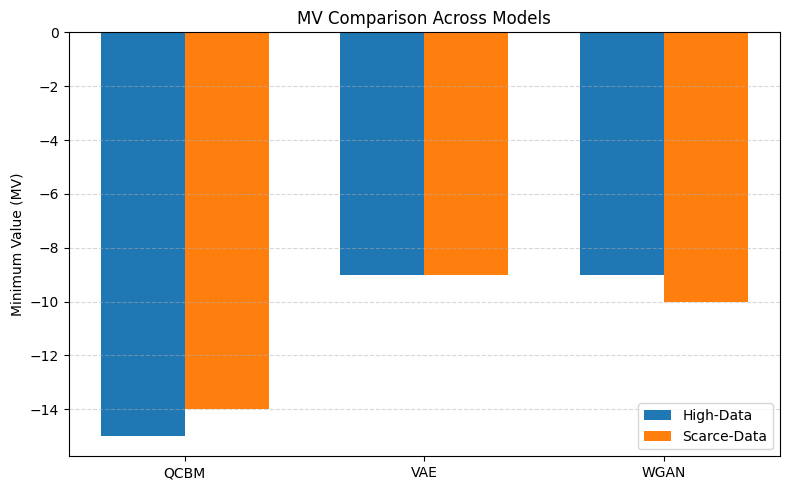

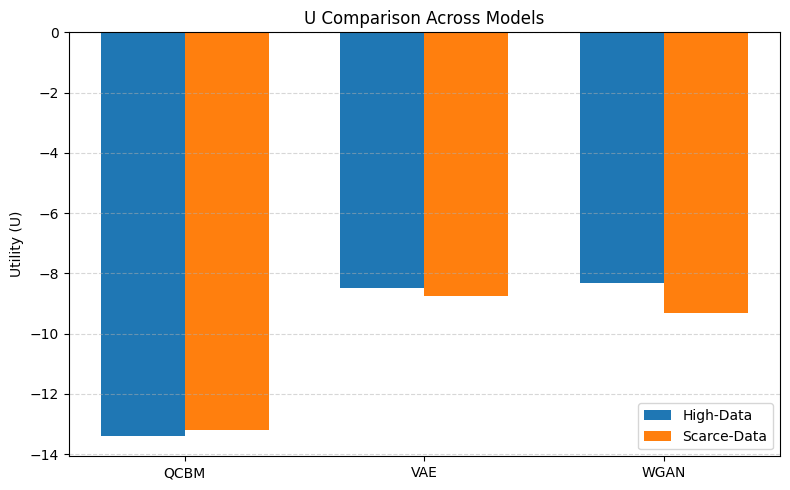

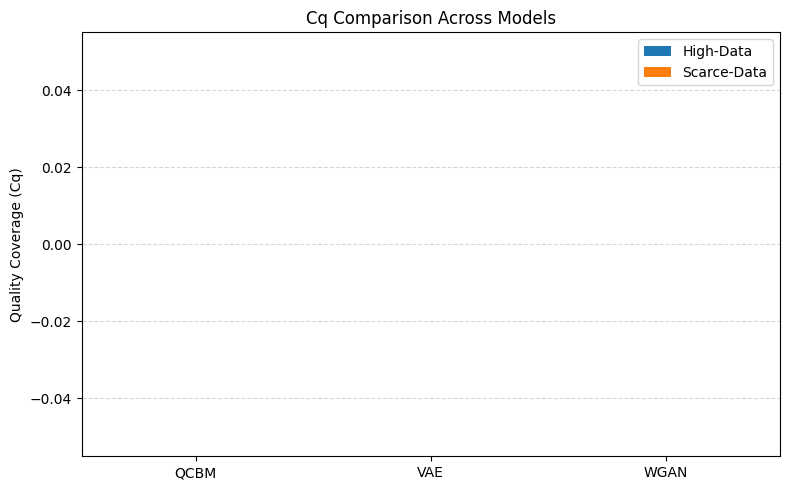

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Evaluation Metrics
# ----------------------------
# Format: [QCBM, VAE, WGAN]
models = ["QCBM", "VAE", "WGAN"]

mv_high = [-15, -9, -9]
mv_scarce = [-14, -9, -10]

u_high = [-13.40, -8.50, -8.33]
u_scarce = [-13.20, -8.75, -9.33]

cq_high = [0.00, 0.00, 0.00]
cq_scarce = [0.00, 0.00, 0.00]

x = np.arange(len(models))
width = 0.35

# ----------------------------
# Plot: Minimum Value (MV)
# ----------------------------
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, mv_high, width, label="High-Data")
plt.bar(x + width/2, mv_scarce, width, label="Scarce-Data")
plt.xticks(x, models)
plt.ylabel("Minimum Value (MV)")
plt.title("MV Comparison Across Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ----------------------------
# Plot: Utility (U)
# ----------------------------
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, u_high, width, label="High-Data")
plt.bar(x + width/2, u_scarce, width, label="Scarce-Data")
plt.xticks(x, models)
plt.ylabel("Utility (U)")
plt.title("U Comparison Across Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ----------------------------
# Plot: Quality Coverage (Cq)
# ----------------------------
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, cq_high, width, label="High-Data")
plt.bar(x + width/2, cq_scarce, width, label="Scarce-Data")
plt.xticks(x, models)
plt.ylabel("Quality Coverage (Cq)")
plt.title("Cq Comparison Across Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()